In [45]:
import numpy as np
import tqdm
import scipy
import pickle
import tools
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
statistics = {'a': 2.542562886886376,
  'loc': -1.114525560819975,
  'scale': 1.4973819434202296,
  'CV': 0.41696167189340216,
  'n': 33539}

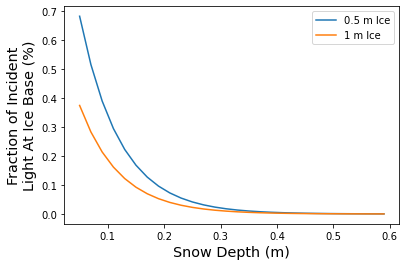

In [65]:
def get_light(incident_light,snow_depth,ice_thickness):
    
    """Gets light transmittance through slab"""

    E_s = 14
    E_i = 1.2
    
    snow_transmitted = incident_light*0.05
    
    incident_ice = snow_transmitted*np.exp(-E_s*snow_depth)
    
    trans_ice = incident_ice * 0.5
    
    incident_bot = trans_ice*np.exp(-E_i*ice_thickness)
    
    return incident_bot
    
ls1 = [] 
ls2 = []
sds = np.arange(0.05,0.6,0.02)
for i in sds:
    ls1.append( get_light(100,i,0.5) )
    ls2.append( get_light(100,i,1) )

    
plt.plot(sds,ls1,label='0.5 m Ice')
plt.plot(sds,ls2,label='1 m Ice')
plt.ylabel('Fraction of Incident\nLight At Ice Base (%)',fontsize='x-large')
plt.xlabel('Snow Depth (m)',fontsize='x-large')
plt.legend()

plt.savefig('figures/light_loss_plot.jpg',bbox_inches='tight',dpi=400)

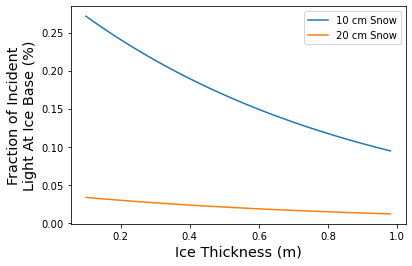

In [68]:
ls1 = [] 
ls2 = []

its = np.arange(0.1,1,0.02)

for i in its:
    
    ls1.append( get_light(100,0.15,i) )
    ls2.append( get_light(100,0.3,i) )

    
plt.plot(its,ls1,label='10 cm Snow')
plt.plot(its,ls2,label='20 cm Snow')
plt.ylabel('Fraction of Incident\nLight At Ice Base (%)',fontsize='x-large')
plt.xlabel('Ice Thickness (m)',fontsize='x-large')
plt.legend()

plt.savefig('figures/light_loss_plot_IT.jpg',bbox_inches='tight',dpi=400)

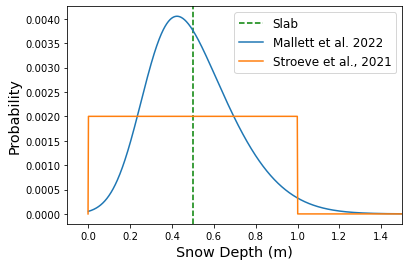

In [69]:
bin_width = 0.002
bin_edges = np.arange(0,2,bin_width)

mean_depth = 0.5

depth_bins, probability = tools.depth_distribution_from_depth(mean_depth=mean_depth,
                                                           dep_bin_edges=bin_edges,
                                                       statistics=statistics)
        
stroeve = [0] + [1/(2*mean_depth)*bin_width  if x<mean_depth*2 else 0 for x in depth_bins]
        
        
plt.axvline(mean_depth,color='g',ls='--',label='Slab')
plt.plot(depth_bins,probability,label='Mallett et al. 2022')
plt.plot([-0.001]+list(depth_bins),stroeve,label='Stroeve et al., 2021')

plt.xlim(-0.1,1.5)

plt.legend(fontsize='large')

plt.ylabel('Probability', fontsize='x-large')
plt.xlabel('Snow Depth (m)', fontsize='x-large')

plt.savefig('figures/distributions.jpg',bbox_inches='tight',dpi=400)

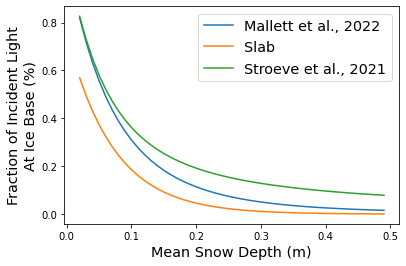

In [71]:
bin_width = 0.0002
bin_edges = np.arange(0,2,bin_width)

SL_eff = []
SN_eff = []
ST_eff = []

mean_depths = np.arange(0.02,0.5,.01)

for mean_depth in mean_depths:
    
    ### Get the Skew-Normal Depth Distribution
    
    depth_bins, SN_probability = tools.depth_distribution_from_depth(mean_depth=mean_depth,
                                                           dep_bin_edges=bin_edges,
                                                       statistics=statistics)
    
    ### Get the Stroeve 2021 Depth Distribution
    
    ST_probability = [1/(2*mean_depth)*bin_width  if x<mean_depth*2 else 0 for x in depth_bins]
    
    ### Get the light transmission through the depth bins
    
    light_bins = get_light(100,depth_bins,0.7)
    
    ### Integrate the light transmission with respect to the two PDFs
    
    dist_cond_SN = np.sum(np.multiply(light_bins,SN_probability))
    
    dist_cond_ST = np.sum(np.multiply(light_bins,ST_probability))
    
    SN_eff.append( dist_cond_SN ) #Skewnormal
    ST_eff.append( dist_cond_ST ) #Stroeve
    SL_eff.append( get_light(100,mean_depth,1)) #Slab
                               
plt.plot(mean_depths, SN_eff, label='Mallett et al., 2022') 
plt.plot(mean_depths, SL_eff, label='Slab')
plt.plot(mean_depths, ST_eff, label='Stroeve et al., 2021')
plt.ylabel('Fraction of Incident Light\nAt Ice Base (%)', fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)', fontsize='x-large')
plt.legend(fontsize='x-large')
# plt.show()

plt.savefig('figures/integrations.jpg',bbox_inches='tight',dpi=400)

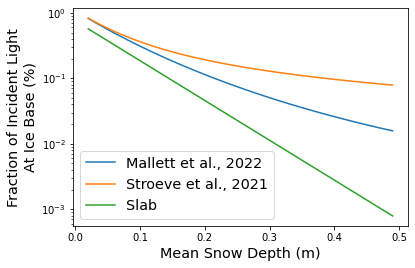

In [72]:
plt.plot(mean_depths, SN_eff, label='Mallett et al., 2022')                            
plt.plot(mean_depths, ST_eff, label='Stroeve et al., 2021')                            
plt.plot(mean_depths, SL_eff, label='Slab')
plt.yscale('log')
plt.ylabel('Fraction of Incident Light\nAt Ice Base (%)',fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)',fontsize='x-large')
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig('figures/integrations_log.jpg',bbox_inches='tight',dpi=400)

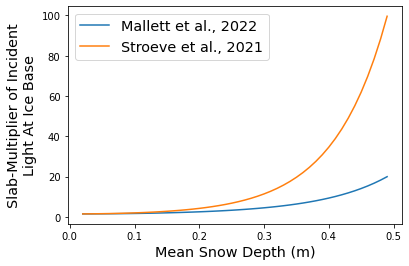

In [73]:
plt.plot(mean_depths, np.divide(SN_eff,SL_eff),label='Mallett et al., 2022')  
plt.plot(mean_depths, np.divide(ST_eff,SL_eff),label='Stroeve et al., 2021')
plt.ylabel('Slab-Multiplier of Incident\nLight At Ice Base',
           fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)',fontsize='x-large')
# plt.yscale('log')
# plt.legend(fontsize='x-large')
tix = [1,2,4,8,16,32]
# plt.yticks(tix,labels=tix)
plt.legend(fontsize='x-large')

plt.savefig('figures/multipliers.jpg',bbox_inches='tight',dpi=400)

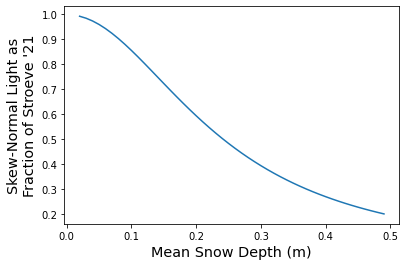

In [77]:
plt.plot(mean_depths, np.divide(SN_eff,ST_eff),label='Mallett et al., 2022')  
plt.ylabel("Skew-Normal Light as\nFraction of Stroeve '21",
           fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)',fontsize='x-large')
# plt.yscale('log')
# plt.legend(fontsize='x-large')
tix = [1,2,4,8,16,32]
# plt.yticks(tix,labels=tix)
# plt.legend(fontsize='x-large')

plt.savefig('figures/multiplier_ST.jpg',bbox_inches='tight',dpi=400)